In [1]:
# Import different libraries
import cv2 # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from random import shuffle
import _pickle as pickle
import gc
import time

from ipywidgets import widgets


# Import Deep Learning libraries
from fastai.vision import*
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import optim
from torchsummary import summary
from torch.distributions.chi2 import Chi2
from sklearn.metrics import roc_auc_score,roc_curve

# Import custom libraries
# import utils as my_utils



In [2]:
# use gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = '../../DAGM2007/'
patch_size = 17
step = 2
bs = 32

bs = 1
vgg_feat = False#False
random_projection=False
norm_before = True 

In [4]:
class MahalanobisLayer(nn.Module):
    def __init__(self, patch_size=17,step=2,compressed_dim=None,random_projection=True,vgg_feat=False,batchsize=1):
        super(MahalanobisLayer, self).__init__()
        self.patch_size=patch_size
        self.step = step
        self.rp = random_projection
        self.vgg = vgg_feat
        self.bs=batchsize
        
        if random_projection:
            if compressed_dim is None:
                compressed_dim = int(np.floor(patch_size**2/4))
            self.cd = compressed_dim
        elif vgg_feat:
            self.cd = 64
        else:
            self.cd = int(patch_size**2)
        
        if batchsize>1:
            self.bn = nn.BatchNorm1d(self.cd,affine=False,track_running_stats=False)
        # chi2 pdf
        self.chi2 = Chi2(self.cd)
        
        # get patches
        if random_projection:
            self.get_patch = nn.utils.weight_norm(nn.Conv2d(1,self.cd,patch_size,padding=0,stride=step), name='weight')
        else:
            self.get_patch = nn.Unfold(patch_size, padding=0, stride=step)

        
    def mahalanobis_distance(self,x):
        if self.vgg:
            d1,d2 = x.shape[2]//self.step,x.shape[3]//self.step
        else:
            d1,d2 = int(x.shape[2]/self.step-np.floor(patch_size/2)),int(x.shape[3]/self.step-np.floor(patch_size/2))
#         
        N = d1*d2
        # reshape to matrix form and subtract mean
        x = self.get_patch(x)
        if self.rp:
            x = x.view(x.shape[0],self.cd,N)
        elif self.vgg:
            x = x.view(x.shape[0],x.shape[1],N)
        
        if self.bs>1:
            x = self.bn(x)
        else:
            x = x-x.mean(dim=2,keepdim=True)
        # get covariance
        cov = x.matmul(x.transpose(2,1)).div(N)

        # get singular value decomposition
        u,s,v = torch.svd(cov,some=False)
        
        norm = torch.diag_embed(1/s.sqrt())
        zca = u.matmul( norm.matmul(u.transpose(2,1)) )
        
        white = zca.matmul(x)
        white = (white**2).sum(dim=1,keepdim=True)

        return white.view(white.shape[0],d1,d2,1)
        
    def forward(self, inp):
        patches = self.mahalanobis_distance( inp )
        return self.chi2.log_prob(patches)

In [14]:
class MahNet(nn.Module):
    def __init__(self,random_projection=False,vgg_feat=False,batchsize=1):
        super(MahNet, self).__init__()
        self.vgg_feat=vgg_feat
        if vgg_feat:
            self.vgg = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:5])
#             print(self.vgg)
            self.md =  MahalanobisLayer(1,1,random_projection=False) #random_projection) )
        else:
            self.md = MahalanobisLayer(random_projection=random_projection,vgg_feat=vgg_feat,batchsize=batchsize)
        
        
    def prep(self,x):
        return torch.cat([x]*3,1)*4-1.6
            
        
    def forward(self, inp):
        if self.vgg_feat:
            x = self.vgg(self.prep(inp))
#             print(x.shape)
            return self.md(x)
        else:
            return self.md(inp)
    
model = MahNet(random_projection,vgg_feat=vgg_feat,batchsize=bs)
model.requires_grad=False
model#.eval()
model = model.to(device)
summary(model, input_size=(1, 512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1           [-1, 289, 61504]               0
  MahalanobisLayer-2          [-1, 248, 248, 1]               0


AttributeError: 'int' object has no attribute 'numpy'

In [15]:
def torchify(im):
    im = np.float32(im)/255.*2-1
    if len(im.shape)>2:
        im = im.reshape(im.shape[0],1,im.shape[1],im.shape[2])
    else:
        im = im.reshape(1,1,im.shape[0],im.shape[1])
    return torch.from_numpy(im).float().cuda()

def npfy(im): 
#     print('im:',im.shape)
    if im.shape[0]==1:
#         print('check')
        return np.squeeze( im[0].data.cpu().numpy() )
    else:
        return np.squeeze( im.data.cpu().numpy() )

def predict(model,img,show=False):
    p = npfy(model(torchify(img)))
#     print(p.shape)
    if show:
        if len(p.shape)>2:
            plt.imshow(p[0],cmap='jet'),plt.show()
        else:
            plt.imshow(p,cmap='jet'),plt.show()
    return p

def get_prototype(files,n=100):
    P = []
    for f in files[:n]:
        P.append(cv2.imread(f,0))
    return np.nanmean(np.array(P,dtype=np.float32),0),np.nanstd(np.array(P,dtype=np.float32),0)
    
def get_preds(files,m,norm=None,std=None,batchsize=1):
    if batchsize>1:
        return get_batched_preds(files,m,bs=batchsize,norm=norm,std=std)
    else:
        P = []
        for f in files:
            im = cv2.imread(f,0)
            if norm is not None:
                im = np.float32(im)-norm
                im = im/std
            # show first result
            if f == files[0]:
                p = predict(m,im,show=True)
            else:
                p = predict(m,im)
            P.append(p.copy())
        return np.asarray(P)

def get_batched_preds(files,m,bs=16,norm=None,std=None):
    P = []
    batch=[]
    z = 0
    for f in files:
        im = cv2.imread(f,0)
        if norm is not None:
            im = np.float32(im)-norm
            im = im/std
        batch.append(im)
        
        if len(batch)==bs:
            
            if z == 0:
                p = predict(m,np.array(batch),show=True)
                P.extend(p.copy())
            else:
                p = predict(m,batch)
                P.append(p[-1].copy())
            z = 1
            batch.pop(0)
#         print(len(P),len(files))
     
    return np.asarray(P)

def scale_01(x):
    x-=np.nanmin(x)
    return x/(.0001+np.nanmax(x))

In [16]:
# Class = ['1','2','3','4','5','6','7','8','9','10']
# for c in Class:
#     Files = glob.glob(path+'Class'+c+'/*.png')+glob.glob(path+'Class'+c+'/*.PNG')
#     Files_def = glob.glob(path+'Class'+c+'_def/*.png')+glob.glob(path+'Class'+c+'_def/*.PNG')
    
#     for f in Files_def[:2]:
#         predict(model,cv2.imread(f,0),show=True)

class1_patchsize17_step2_normbefore


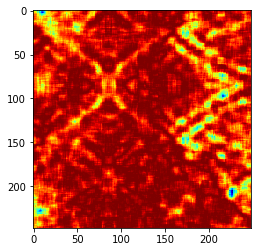

takes: ~ 0.048887732293870716 s


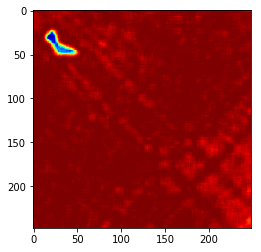

(800,) (150,)


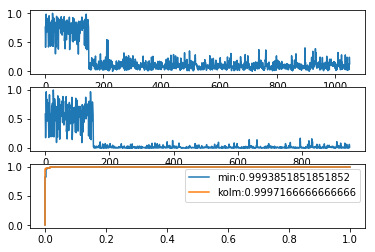

class2_patchsize17_step2_normbefore


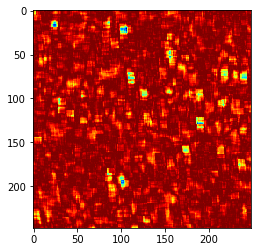

takes: ~ 0.04631143967310587 s


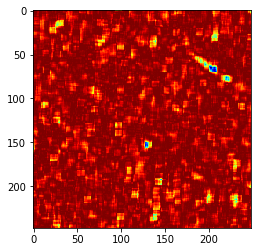

(800,) (150,)


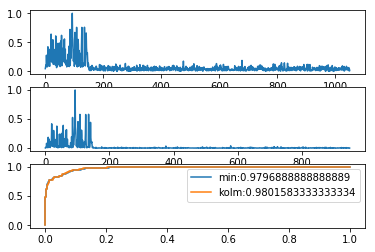

class3_patchsize17_step2_normbefore


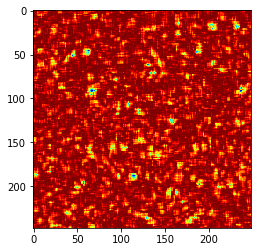

takes: ~ 0.049073769251505535 s


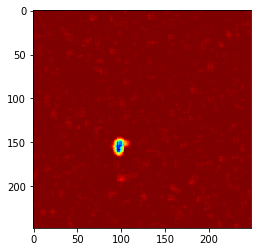

(800,) (150,)


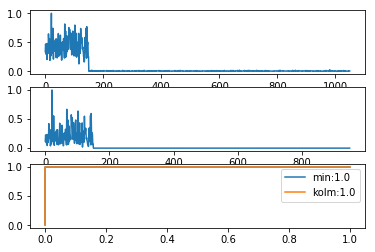

class4_patchsize17_step2_normbefore


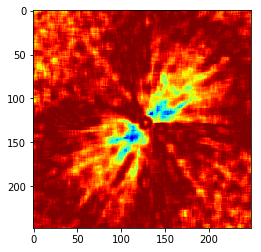

takes: ~ 0.048412631617652045 s


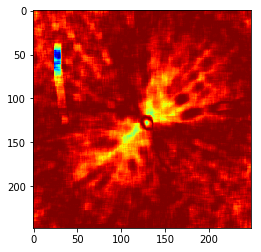

(800,) (150,)


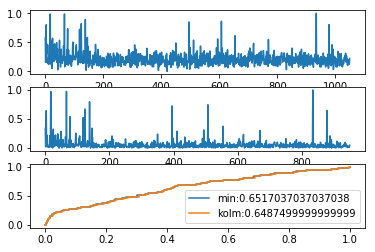

class5_patchsize17_step2_normbefore


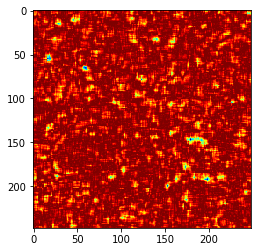

takes: ~ 0.04752720806333754 s


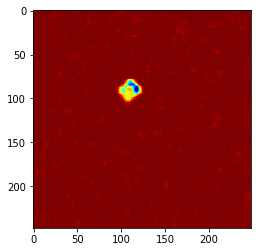

(800,) (150,)


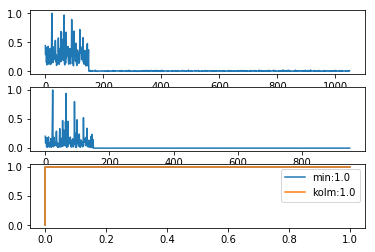

class6_patchsize17_step2_normbefore


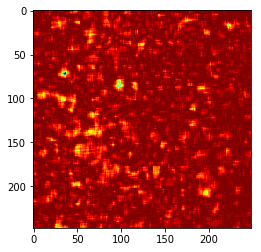

takes: ~ 0.048272882567511666 s


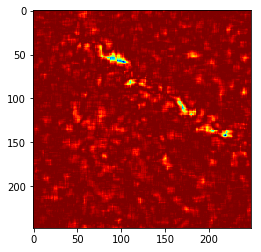

(800,) (150,)


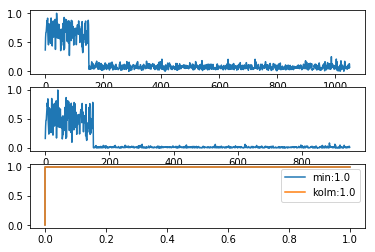

class7_patchsize17_step2_normbefore


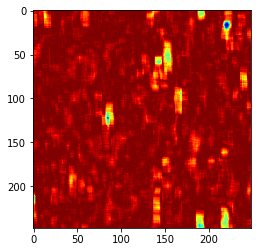

takes: ~ 0.04776650407097557 s


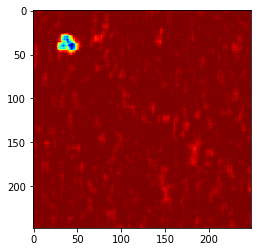

(2100,) (308,)


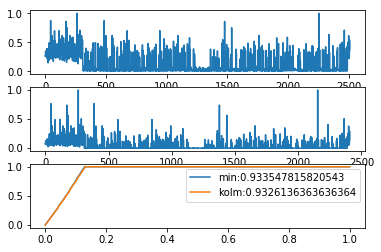

class8_patchsize17_step2_normbefore


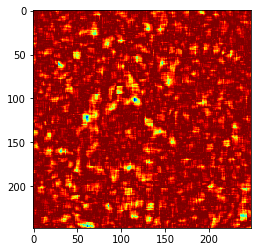

takes: ~ 0.04778824535464805 s


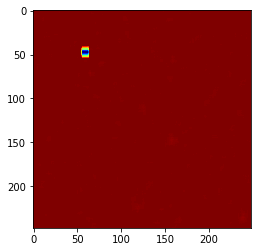

(1869,) (308,)


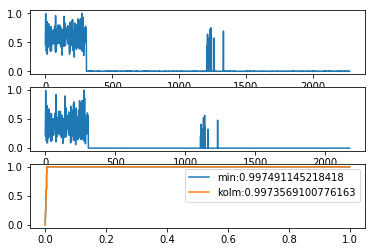

class9_patchsize17_step2_normbefore


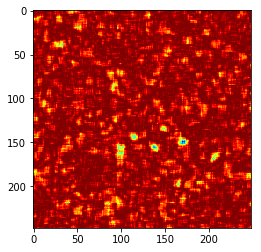

takes: ~ 0.04677788172076467 s


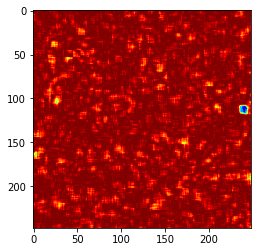

(1818,) (309,)


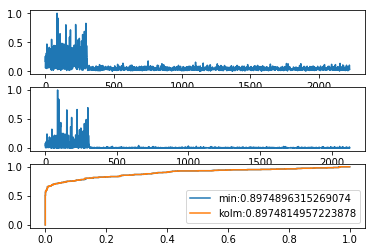

class10_patchsize17_step2_normbefore


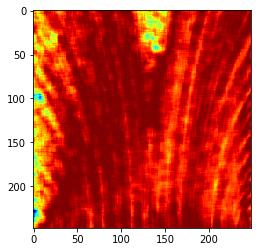

takes: ~ 0.04899823601065129 s


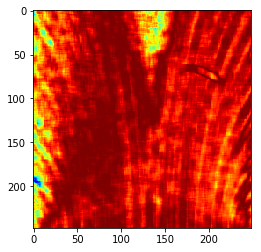

(2116,) (308,)


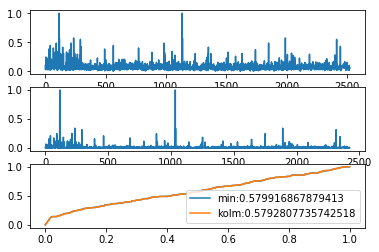

In [17]:
T = []
AUCs = []
K = []
Class = ['1','2','3','4','5','6','7','8','9','10']
for c in Class:
    
    Files = np.sort( glob.glob(path+'Class'+c+'/*.png')+glob.glob(path+'Class'+c+'/*.PNG') )
    Files_def = np.sort( glob.glob(path+'Class'+c+'_def/*.png')+glob.glob(path+'Class'+c+'_def/*.PNG') )
    Norm = None
    STD = None
    fname = 'class'+c+'_patchsize'+str(patch_size)+'_step'+str(step)
    if random_projection:
        fname+='_RP'
    if norm_before:
        fname+='_normbefore'
        Norm,STD = get_prototype(Files)
        Files = Files[100:]
    if bs>1:
        fname+='_bn'+str(bs)
    print(fname)
    
    if os.path.isfile('results/'+fname+'.pred1'):
        P_good,P_bad = pickle.load(open('results/'+fname+'.pred','rb'))
        print('found previous save...',P_good.shape,P_bad.shape)
    else:
        t0 = time.time()
        
        P_good = get_preds(Files,model,Norm,STD,bs)
        print('takes: ~',(time.time()-t0)/len(Files),'s')
        P_bad = get_preds(Files_def,model,Norm,STD,bs)
        pickle.dump((P_good,P_bad),open('results/'+fname+'.pred','wb'),-1)
        
    # normalization:
    if not norm_before:
        mu = np.nanmean(P_good[:100],0)
        sigma = (.0001+np.nanstd(P_good[:100],0))
        P_good = P_good[100:]-mu
        P_good/= sigma
        P_bad = P_bad-mu
        P_bad/= sigma
        
    min_good = np.nanmin(P_good.reshape(len(P_good),-1),axis=1)
    min_bad = np.nanmin(P_bad.reshape(len(P_bad),-1),axis=1)
    
    
    prototype = np.sort(np.nanmean(P_good.reshape(len(P_good),-1)[:100],0))
#     prototype = np.nanmean(np.sort(P_good.reshape(len(P_good),-1)[:100],axis=1),0)
    cumu1 = np.nanmax( (np.sort(P_good.reshape(len(P_good),-1),axis=1)[100:]-prototype)**2,axis=1 )
    cumu2 = np.nanmax( (np.sort(P_bad.reshape(len(P_bad),-1),axis=1)-prototype)**2,axis=1 )
    print(cumu1.shape,cumu2.shape)
    K = np.concatenate((cumu2,cumu1),axis=0)
    
    y_pred = np.concatenate((min_bad,min_good),axis=0)
            
    # scale to 0-1
    y_pred = 1-scale_01(y_pred)
    K = scale_01(K)

    plt.subplot(311)
    plt.plot(y_pred)
    plt.subplot(312)
    plt.plot(K)
            
    y_targ = np.zeros(len(y_pred))
    y_targ2 = np.zeros(len(K))
    y_targ[:len(min_bad)] = 1
    y_targ2[:len(min_bad)] = 1
    auc1 = roc_auc_score(y_targ,y_pred)
    auc2 = roc_auc_score(y_targ2,K)
    fpr1,tpr1,thr1 = roc_curve(y_targ,y_pred)
    fpr2,tpr2,thr2 = roc_curve(y_targ2,K)
    
    plt.subplot(313)
    plt.plot(fpr1,tpr1,label='min:'+str(auc1))
    plt.plot(fpr2,tpr2,label='kolm:'+str(auc2))
    plt.legend()
    plt.show()
    AUCs.append(auc1)
pickle.dump(np.array(AUCs),open('results/'+fname+'.aucs','wb'))

4


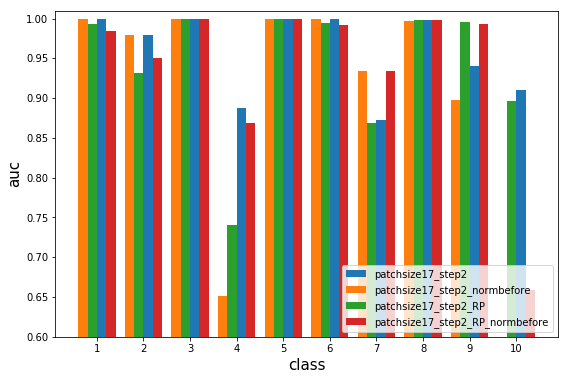

In [20]:
Files = glob.glob('results/*.aucs')
print(len(Files))
A = []
for f in Files:
    A.append( pickle.load(open(f,'rb')) )
A = np.asarray(A)

plt.figure(1,figsize=(9,6))
xrange=np.arange(0,10,1)
plt.bar(xrange+.1,A[2],width=.2,label=Files[2].split('/')[-1][8:-5])#label='17x17')
plt.bar(xrange-.3,A[0],width=.2,label=Files[0].split('/')[-1][8:-5])#'17x17, normalized'
plt.bar(xrange-.1,A[1],width=.2,label=Files[1].split('/')[-1][8:-5])#'17x17, RP'
plt.bar(xrange+.3,A[3],width=.2,label=Files[3].split('/')[-1][8:-5])#'17x17, RP, normalized'
plt.legend(loc=4)
plt.ylim([.6,1.01])
plt.xticks(xrange,[1,2,3,4,5,6,7,8,9,10])
plt.ylabel('auc',fontsize=15)
plt.xlabel('class',fontsize=15)
plt.savefig('Result.svg',dpi=300)
plt.savefig('Result.pdf',dpi=300)
plt.show()